## DAY3 宿題
    Kickstarter Projectsの分類

- DAY_1
    - 使える説明変数の仕分け
    - 日付データを期間に変換
    - 正解データを[0, 1]に変換
    
- DAY_2
    - 外れ値除去（感覚）
    - 標準化
    - ロジスティック回帰による分類
    - K_Fold法による評価

- DAY_3
    - カテゴリ変数の追加
    - 相関の高そうなデータの選択（感覚）
    - 決定木による分類
    - ランダムフォレストによる分類

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

# DAY_1 4_linear_regression_multi_real_data
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# DAY_1 6_logistic_regression_real_data
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix

# DAY_2 1_how_to_validation
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数

In [2]:
# DAY_3 5_descision_tree
import graphviz
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO

from sklearn.tree import DecisionTreeClassifier, export_graphviz

# DAY_3 6_random_forest
from sklearn.ensemble import RandomForestClassifier

In [3]:
# https://qiita.com/Sasagawa0185/items/1185933dd0e560a26b07
import datetime

# 与えられた文字列型の時刻をdatetime型へ変換する関数
def str2datetime(t, format):
    return datetime.datetime.strptime(t, format)

# 差を秒に直したものを一日当たりの秒数でわったものを出力します
# 単位：日
def dateDiff(t):
    t1, t2 = t
    delta = t2 - t1
    return delta.total_seconds()/(60*60*24)

In [4]:
def standardize(df):
    return (df-df.mean())/df.std(ddof=True)
def normalize(df):
    return (df - df.min())/(df.max()-df.min())

### 1. データの読み込み

In [5]:
df_house = pd.read_csv("kickstarter-projects/ks-projects-201801.csv", index_col=0)
# 日付を期間に変換し列" dateDiff" に格納
df_house.launched = df_house.launched.apply(str2datetime, format='%Y-%m-%d %H:%M:%S')
df_house.deadline = df_house.deadline.apply(str2datetime, format='%Y-%m-%d')
df_house["dateDiff"] = df_house[["launched", "deadline"]].apply(dateDiff, axis=1)

# 連続量の特徴量（列名）
continuousCols = ["dateDiff", "goal", "usd_goal_real"]

# 離散ラベルの特徴量
quantizedCols = ["category", "main_category", "currency", "country"]

# 固有の列
uniqueCols = ["name"]

# クラウドファウンディング前に利用できないと特徴量
unavailableCols = ["pledged", "backers", "usd pledged", "usd_pledged_real"]

# 明らかに相関高い列が別にあるから使わない特徴量
unuseCol = ["goal"]


### 2. データの前処理

In [6]:
# 答えにするstate列を確認
df_house.state.value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

In [7]:
# failed     -> 0
# successful -> 1
# canceled   -> 0
# others     -> delete
df_house = df_house[df_house.state != "undefined"]
df_house = df_house[df_house.state != "live"]
df_house = df_house[df_house.state != "suspended"]
df_house["stateValue"] = ("successful" == df_house["state"]).astype(float)

In [8]:
# カテゴリデータの確認
# ss_category = df_house.category
# ss_category.value_counts().count()
# -> 159 
# 多すぎる。似てるものを集めたら結局
# main_categoryと相関が高くなるはずなので今回はmain_categoryのみを採用

In [9]:
ss_category = df_house.main_category
ss_category.value_counts()
# データ量にばらつきはあるが、
# main_categoryはこのままやってみる

Film & Video    62282
Music           49254
Publishing      39047
Games           34723
Technology      31765
Design          29516
Art             27863
Food            24265
Fashion         22425
Theater         10850
Comics          10720
Photography     10675
Crafts           8661
Journalism       4672
Dance            3736
Name: main_category, dtype: int64

In [10]:
# country と currency について確認した感じ
# 相関がかなり高いのでcountryを採用し、
# USに偏っているので、USかそれ以外かで分ける
df_house.loc[df_house.country != "US", "country"] = "OTHER"
df_house.country.value_counts()

US       289671
OTHER     80783
Name: country, dtype: int64

In [11]:
# df_dataset の定義
requiredCols = ["stateValue", "dateDiff", "usd_goal_real", "country", "main_category"]
df_dataset = df_house[requiredCols]
# 欠損値を確認
df_dataset.isnull().sum()

stateValue       0
dateDiff         0
usd_goal_real    0
country          0
main_category    0
dtype: int64

In [12]:
# カテゴリ変数をone-hotに変換
df_tmp = pd.get_dummies(df_dataset, drop_first=True, columns=["country"])
df_dataset = pd.get_dummies(df_tmp, columns=["main_category"])
df_dataset.head()

,stateValue,dateDiff,usd_goal_real,country_US,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
ID,,,,,,,,,,,,,,,,,,,
1000002330,0.0,58.491343,1533.95,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1000003930,0.0,59.802813,30000.00,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1000004038,0.0,44.985532,45000.00,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1000007540,0.0,29.858206,5000.00,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1000011046,0.0,55.642326,19500.00,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [13]:
# 要約統計量の表示
df_dataset.describe()

,stateValue,dateDiff,usd_goal_real,country_US,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
count,370454.000000,370454.000000,3.704540e+05,370454.000000,370454.000000,370454.000000,370454.000000,370454.000000,370454.000000,370454.000000,370454.000000,370454.000000,370454.000000,370454.000000,370454.000000,370454.000000,370454.000000,370454.000000,370454.000000
mean,0.361600,33.840772,4.507638e+04,0.781935,0.075213,0.028937,0.023379,0.010085,0.079675,0.060534,0.168123,0.065501,0.093731,0.012612,0.132956,0.028816,0.105403,0.085746,0.029288
std,0.480464,60.693305,1.128265e+06,0.412932,0.263735,0.167631,0.151106,0.099916,0.270790,0.238474,0.373976,0.247408,0.291454,0.111591,0.339527,0.167289,0.307073,0.279989,0.168614
min,0.000000,0.005058,1.000000e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,29.096586,2.000000e+03,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,29.683941,5.500000e+03,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,36.320104,1.596004e+04,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,14866.958333,1.663614e+08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
# 期間（dateDiff）が[長すぎる／短すぎる]データがあるので、
# ひとまず期間が[1年以内／一週間以上]のプロジェクトという条件を追加する
df_dataset = df_dataset[df_dataset.dateDiff < 366]
df_dataset = df_dataset[df_dataset.dateDiff >= 7]
df_dataset.dateDiff.describe()

count    367212.000000
mean         33.852654
std          12.566364
min           7.001424
25%          29.105972
50%          29.704149
75%          36.804042
max          91.962650
Name: dateDiff, dtype: float64

In [15]:
# goalはどの範囲が確からしいか判断できなかったが、
# 100ドル以上, 1,000,000ドル未満という条件でデータセットを構築した
df_dataset = df_dataset[df_dataset.usd_goal_real <= 1000000]
df_dataset = df_dataset[df_dataset.usd_goal_real >= 100]
df_dataset.usd_goal_real.describe()

count     362231.000000
mean       20940.969429
std        60962.963509
min          100.000000
25%         2016.000000
50%         5705.000000
75%        16000.000000
max      1000000.000000
Name: usd_goal_real, dtype: float64

In [16]:
df_dataset.columns

Index(['stateValue', 'dateDiff', 'usd_goal_real', 'country_US',
       'main_category_Art', 'main_category_Comics', 'main_category_Crafts',
       'main_category_Dance', 'main_category_Design', 'main_category_Fashion',
       'main_category_Film & Video', 'main_category_Food',
       'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater'],
      dtype='object')

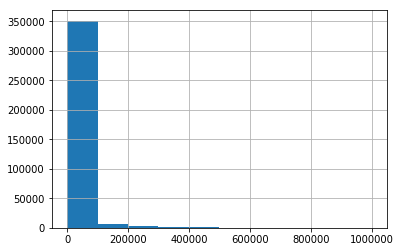

In [17]:
# DAY2フィードバックより分布を確認
df_dataset.usd_goal_real.hist()

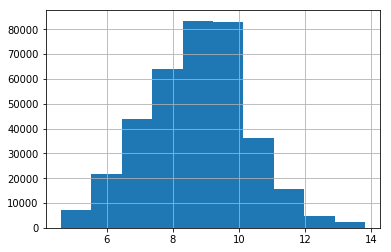

In [18]:
# 対数変換
df_dataset["log_usd_goal_real"] = df_dataset.usd_goal_real.apply(np.log)
df_dataset.log_usd_goal_real.hist()

In [19]:
requiredCols[2] = "log_usd_goal_real"
df_dataset.drop("usd_goal_real", axis=1, inplace=True)
df_dataset = df_dataset.iloc[:,[0,1,18,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]]

In [20]:
# 標準化 dateDiff と goal のみ
df_dataset[requiredCols[1:3]] = df_dataset[requiredCols[1:3]].apply(standardize)
df_dataset.describe()

,stateValue,dateDiff,log_usd_goal_real,country_US,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
count,362231.000000,3.622310e+05,3.622310e+05,362231.00000,362231.000000,362231.000000,362231.000000,362231.000000,362231.000000,362231.000000,362231.000000,362231.000000,362231.000000,362231.000000,362231.000000,362231.000000,362231.000000,362231.000000,362231.000000
mean,0.360284,-4.608869e-14,1.949585e-12,0.78363,0.073876,0.028910,0.023013,0.010176,0.080347,0.060953,0.168558,0.063609,0.093631,0.012451,0.133992,0.028595,0.106090,0.086282,0.029520
std,0.480083,1.000000e+00,1.000000e+00,0.41177,0.261569,0.167553,0.149945,0.100361,0.271829,0.239244,0.374362,0.244055,0.291315,0.110886,0.340644,0.166666,0.307953,0.280780,0.169259
min,0.000000,-2.142886e+00,-2.641903e+00,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-3.800970e-01,-7.038886e-01,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,-3.322342e-01,-3.272430e-02,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,2.386073e-01,6.326448e-01,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,4.632098e+00,3.300692e+00,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 3. データ統計量の確認

In [21]:
# # 【重い】散布図行列を書いてみる
# pd.plotting.scatter_matrix(df_dataset.head(1000), figsize=(10,10))
# plt.show()

In [22]:
# 相関係数を確認
df_dataset[df_dataset.columns[:4]].corr()

,stateValue,dateDiff,log_usd_goal_real,country_US
stateValue,1.000000,-0.116769,-0.227628,0.062642
dateDiff,-0.116769,1.000000,0.163347,0.036815
log_usd_goal_real,-0.227628,0.163347,1.000000,-0.001385
country_US,0.062642,0.036815,-0.001385,1.000000


### 4. 分類

#### 4-1 ロジスティック回帰

In [23]:
y = df_dataset["stateValue"].values
X = df_dataset.drop("stateValue", axis=1).values

test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=test_size, random_state=1234) # ホールドアウト法を実行（調整用データはランダム選択）

In [24]:
# 学習用データを使ってロジスティック回帰モデルを学習
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X_train, y_train)

# 正答率を表示（カッコ内は訓練時の正答率）
print('正答率［ロジスティック回帰］ = {:.3f}% ({:.3f}%)'.format(clf.score(X_test, y_test)*100, clf.score(X_train, y_train)*100))    

# テストデータに対する予測を実行（比較用に訓練データに対する予測も行う）
y_est = clf.predict(X_test)
# テストデータに対する予測と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est), 
                        index=['正解 = False, Canceled', '正解 = Success'], 
                        columns=['予測 = False, Canceled', '予測 = Success'])
display(conf_mat)

正答率［ロジスティック回帰］ = 66.914% (66.983%)


,"予測 = False, Canceled",予測 = Success
"正解 = False, Canceled",41418,5015
正解 = Success,18955,7059


#### 4-2 決定木

In [25]:
# ハイパーパラメータ調整
best_accuracy = 0.0
best_max_depth = 0

for max_depth in [4,6,8,10,12,14]:
    # for min_samples_leaf in [0.1, 0.07, 0.01, 0.007, 0.001, 1e-5]:->1e-5
    clf = DecisionTreeClassifier(
        criterion="gini", 
        max_depth=max_depth, # max_depth:6まで
        min_samples_leaf=1e-5, 
        random_state=1234)

    clf = clf.fit(X_train, y_train)
    if best_accuracy < clf.score(X_val, y_val):
        best_accuracy = clf.score(X_val, y_val)
        best_max_depth = max_depth

max_depth:12
正答率［決定木］=67.360(69.154)


,"予測 = False, Canceled",予測 = Success
"正解 = False, Canceled",38803,7630
正解 = Success,16017,9997


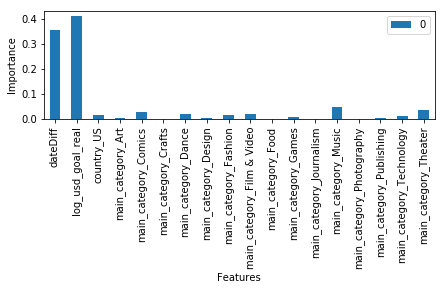

In [26]:
clf = DecisionTreeClassifier(
    criterion="gini", 
    max_depth=best_max_depth, # max_depth:6までしか描画はできない
    min_samples_leaf=1e-5, 
    random_state=1234)

clf = clf.fit(X_train, y_train)

print("max_depth:{}".format(best_max_depth))
print("正答率［決定木］={:.3f}({:.3f})".format(clf.score(X_test, y_test)*100, clf.score(X_train, y_train)*100))

# テストデータに対する予測を実行（比較用に訓練データに対する予測も行う）
y_est = clf.predict(X_test)
# テストデータに対する予測と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est), 
                        index=['正解 = False, Canceled', '正解 = Success'], 
                        columns=['予測 = False, Canceled', '予測 = Success'])
display(conf_mat)

# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
# print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, index=df_dataset.columns[1:]).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

In [27]:
# # 決定木の描画
# # dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.204071 to fit
# dot_data = StringIO() #dotファイル情報の格納先
# export_graphviz(clf, out_file=dot_data,  
#                      feature_names=df_dataset.columns[1:],  
#                      class_names=["Failed or Canceled","Success"],
#                      filled=True, rounded=True,  
#                      special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
# Image(graph.create_png())

In [28]:
# ハイパーパラメータ調整
best_accuracy = 0.0
best_max_depth = 0
# df_hyperParam = pd.DataFrame()
idx = 0
param_range = [1,2,4,6,8,10,12,14,16,18,20]
df_hyper_param = pd.DataFrame({"max_depth":[param_range[0]], "n_estimators":0, "accuracy":0})#.set_index("max_depth")
df_hyper_param

,max_depth,n_estimators,accuracy
0,1,0,0


In [29]:
# # ハイパーパラメータの最適化
# # 長い
# for max_depth in param_range:
#     for n_estimators in param_range:        
#         clf = RandomForestClassifier(
#             n_estimators=10,
#             max_depth=max_depth,
#             criterion="gini",
#             min_samples_leaf=1e-5, 
#             random_state=1234)
#         clf = clf.fit(X_train, y_train)
#         current_accuracy = clf.score(X_val, y_val)
#         df_hyper_param.loc[idx,:] = [max_depth, n_estimators, current_accuracy]
#         if best_accuracy < current_accuracy:
#             best_accuracy = current_accuracy
#             best_max_depth = max_depth
#             best_n_estimators = n_estimators
#         idx += 1
#         print(idx)
# print(best_max_depth) # 14 # 16
# print(best_n_estimators) # 1

In [30]:
# display(df_hyper_param)

正答率［ランダムフォレスト］=66.243(69.015)


,"予測 = False, Canceled",予測 = Success
"正解 = False, Canceled",39137,7296
正解 = Success,17160,8854


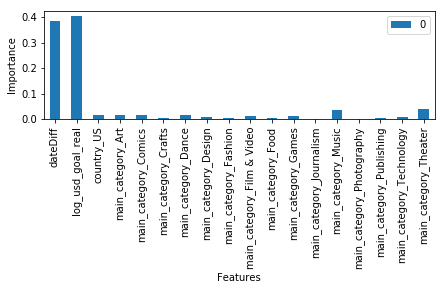

In [31]:
clf = RandomForestClassifier(
    n_estimators=1, 
    max_depth=16,
    criterion="gini",
    min_samples_leaf=1e-5, 
    random_state=1234)
clf.fit(X_train, y_train)

print("正答率［ランダムフォレスト］={:.3f}({:.3f})".format(clf.score(X_test, y_test)*100, clf.score(X_train, y_train)*100))

# テストデータに対する予測を実行（比較用に訓練データに対する予測も行う）
y_est = clf.predict(X_test)
# テストデータに対する予測と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est), 
                        index=['正解 = False, Canceled', '正解 = Success'], 
                        columns=['予測 = False, Canceled', '予測 = Success'])
display(conf_mat)

# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
# print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, index=df_dataset.columns[1:]).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

- できてないこと
    - 正則化
    - SVM
    - 説明変数の選択（分析による）